In [38]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
from tqdm.notebook import tqdm
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3

In [3]:
BASE_DIR = '/kaggle/input/flickr30k'
WORKING_DIR = '/kaggle/working'

In [4]:
model = InceptionV3()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

96112376/96112376 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [5]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'flickr30k_images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(299, 299))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/31783 [00:00<?, ?it/s]

In [6]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'inception_features30k.pkl'), 'wb'))

In [7]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'inception_features30k.pkl'), 'rb') as f:
    features = pickle.load(f)

In [8]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/158916 [00:00<?, ?it/s]

In [10]:
len(mapping)

31783

In [12]:
# # before preprocess of text
# path="/kaggle/input/flickr30k/flickr30k_images"
# l=os.listdir(path)
# c=0
# for i in l:
#     p=path+'/'+i
#     img=load_img(p,target_size=(299,299,3))
#     plt.imshow(img)
#     plt.axis('off')
#     plt.show()
#     cap=str(i).split(".")
#     print(mapping[cap[0]])
#     c+=1
#     if c>10:
#         break

In [13]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
        # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in         caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [16]:
clean(mapping)

In [11]:
# # after preprocess of text
# path="/kaggle/input/flickr30k/flickr30k_images"
# l=os.listdir(path)
# c=0
# for i in l:
#     p=path+'/'+i
#     img=load_img(p,target_size=(299,299,3))
#     plt.imshow(img)
#     plt.axis('off')
#     plt.show()
#     cap=str(i).split(".")
#     print(mapping[cap[0]])
#     c+=1
#     if c>10:
#         break

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [17]:
len(all_captions)

158915

In [18]:
all_captions[:10]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

In [19]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [20]:
vocab_size

18319

In [21]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

74

In [22]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [29]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

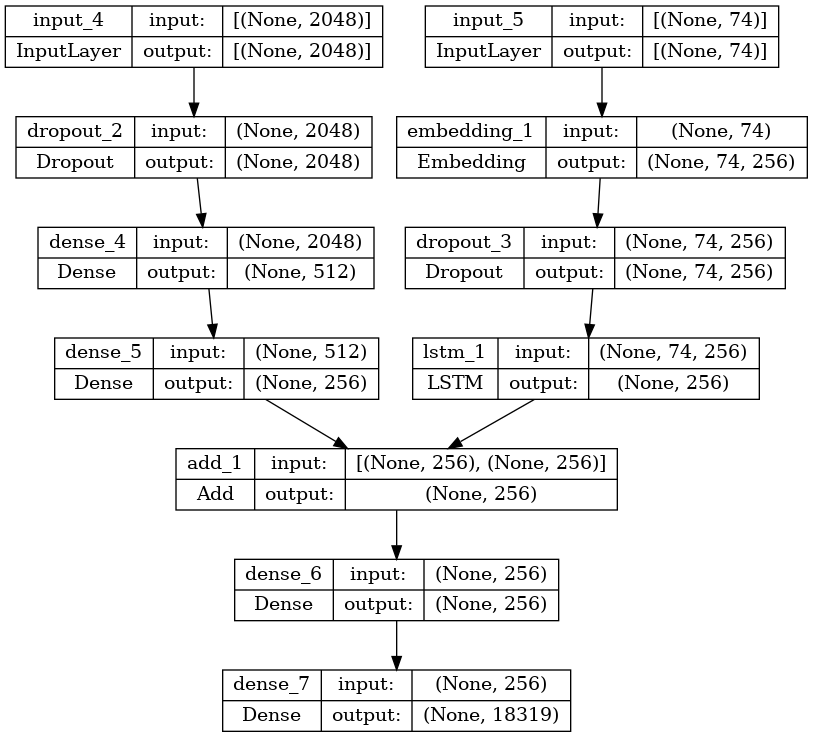

In [30]:
# encoder model
# image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(512, activation='relu')(fe1)
fe3= Dense(256, activation='relu')(fe2)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe3, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [32]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [28]:
# save the model
model.save(WORKING_DIR+'/inceptionv3_flickr30k_model30k.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [46]:
loaded_model = keras.models.load_model('/kaggle/input/inceptionv3-flickr30k-model30k/inceptionv3_flickr30k_model30k.h5')

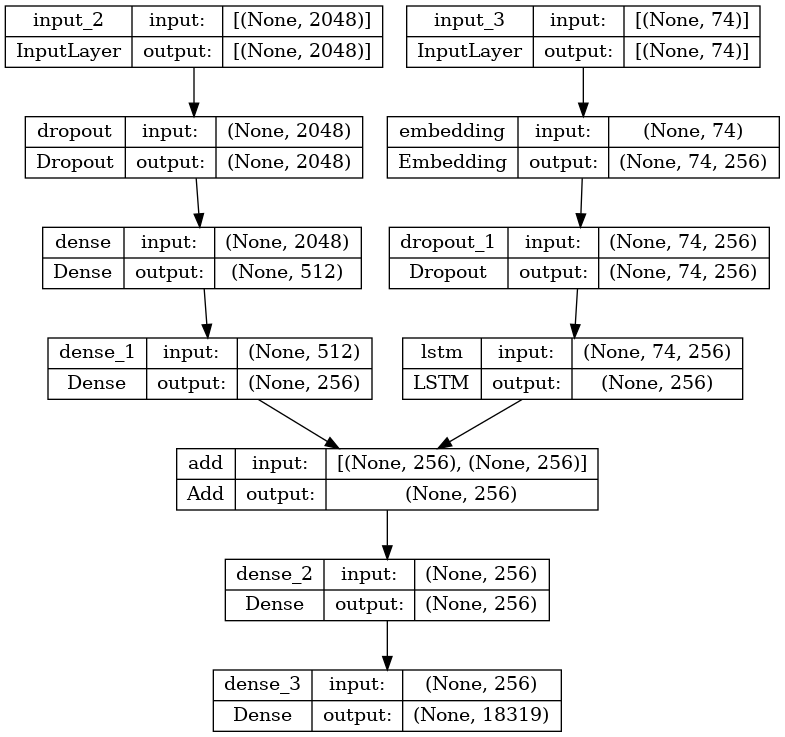

In [47]:
plot_model(loaded_model, show_shapes=True)

In [48]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [49]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [50]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(loaded_model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
b1=corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
b2=corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
b3= corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
b4=corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
print("BLEU-1: %f" % b1)
print("BLEU-2: %f" % b2)
print("BLEU-3: %f" % b3)
print("BLEU-4: %f" % b4)

  0%|          | 0/3179 [00:00<?, ?it/s]

BLEU-1: 0.469754
BLEU-2: 0.209127
BLEU-3: 0.112608
BLEU-4: 0.054758
